<center> <h2>Vibration Anomaly Detection</h2> </center>


**Goal** : An anomaly detection model for vibration failure dataset


**Dataset** : vibration sensor readings from four bearings. Dataset is sourced from The NASA Acoustics and Vibration Database

## A. Loading of Dataset

In [1]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
sns.set(color_codes=True)
import glob

import pickle
import joblib
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers

In [2]:
df_filename = "BearingVibration_Dataset.csv"
df = pd.read_csv(df_filename, index_col="Unnamed: 0")

## B. Exploratory Data Analysis

In [3]:
df

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786


In [4]:
# total missing value each columns
for col in df.columns.tolist():
    print('{} column missing values: {}'.format(col, df[col].isnull().sum()))

Bearing 1 column missing values: 0
Bearing 2 column missing values: 0
Bearing 3 column missing values: 0
Bearing 4 column missing values: 0


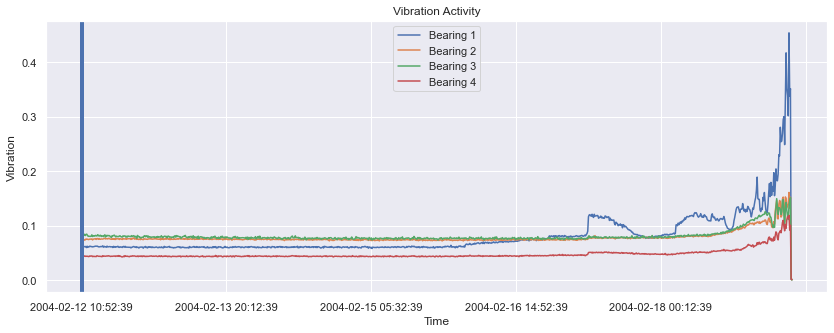

In [5]:
# Visualisation Data
ax = df.plot(figsize = (14,5), title="Vibration Activity" , legend = True)
ax.set(xlabel="Time", ylabel="Vibration")
plt.axvline(x=df.index[-1], linewidth=4, color='b')

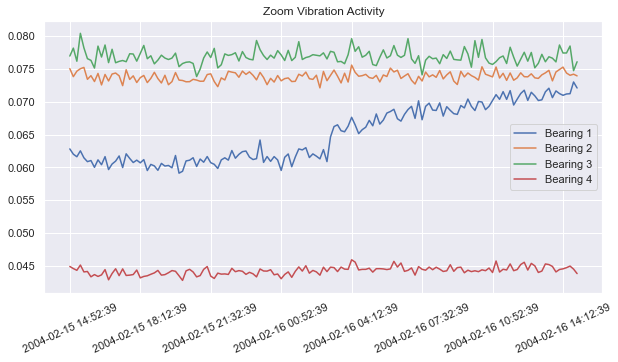

In [7]:
df['2004-02-15 14:52:39':'2004-02-16 14:52:39'].plot(figsize = (10,5), title="Zoom Vibration Activity" , legend = True)
ax.set(xlabel="Time", ylabel="Vibration")
plt.xticks(rotation=25);

>- **start_date** : 2004-02-12 10:52:39 
>- **end_date** : 2004-02-19 06:22:39
>- **range** : 10 min
>- **missing values** : 0
>- **total data** : 982
>- Bearings vibration time series shows the characteristics of consistency range and predictability anomaly
>- Vibration Bearing 1 start increase before 2004-02-16 04:12:39

## C. Data Preparation

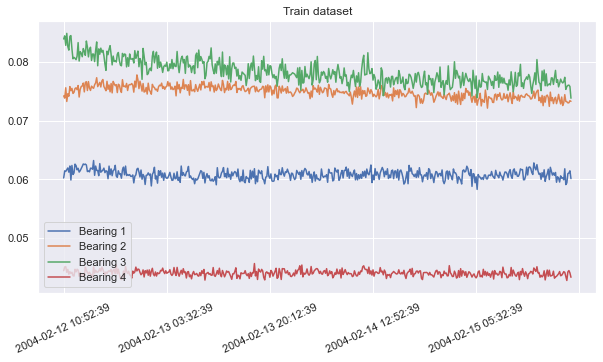

In [6]:
# split dataset
train_df = df[:'2004-02-15 20:52:39'] # represent normal operating conditions
test_df = df['2004-02-15 20:52:39':] # leading up to the bearing failure
train_df.plot(figsize = (10,5), title="Train dataset" , legend = True) 
plt.xticks(rotation=25);

In [7]:
# Standardize the data.
scaler = StandardScaler()
scaler = scaler.fit(train_df)
x_train = pd.DataFrame(scaler.transform(train_df),
                       columns=train_df.columns, index=train_df.index)
x_test = pd.DataFrame(scaler.transform(test_df),
                       columns=test_df.columns, index=test_df.index)

### D. Modelling

**Comparing Methods**

 Comparing methods based on the Journal "Review of Vibration-Based Structural Health Monitoring Using Deep Learning" [1]. There are several studies related to vibration health monitoring on bearings, using the Sparse Autoencoder (SAE) and Denoising Autoencoder (DAE) methods.

<img src="image/table_1_comparing methods.png" alt="drawing" width="600"/>

<img src="image/table_2_comparing methods.png" alt="drawing" width="600"/>

In this task with relative stable dataset on normal operating conditions, the approach used is simpler and effective, Autoencoder.

In [10]:
## modelling
for i, col_name in enumerate(df.columns):
    print('================= TRAINING %s =================='%col_name)
    curr_xtrain = np.array(x_train[[col_name]])
    
    autoencoder = Sequential()
    autoencoder.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(curr_xtrain.shape[1],)))
    autoencoder.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))
    autoencoder.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))
    autoencoder.add(Dense(curr_xtrain.shape[1],
                kernel_initializer='glorot_uniform'))
    autoencoder.compile(optimizer='adam', loss="mse")
    
    # fitting the model
    hist = autoencoder.fit(curr_xtrain, curr_xtrain, batch_size=10, 
                  epochs=30,validation_split=0.05,verbose = 1)
    
    # save model to model path
    autoencoder.save("model/model_%s.h5"%col_name)
    
    # visualize training-validation loss
    plt.plot(hist.history['loss'],'r',label='Training loss')
    plt.plot(hist.history['val_loss'],'b',label='Validation loss')
    plt.title("Training-Validation Loss %s"%col_name)
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss [mse]')
    plt.ylim([0,.1])
    plt.savefig('image/plot_training-validation loss_%s.png'%col_name)
   
    plt.close()
    
    print('\n================== DONE ===================')

================= TRAINING Bearing 1 ==================
Epoch 1/30
47/47 [==============================] - 1s 8ms/step - loss: 0.8449 - val_loss: 0.5137
Epoch 2/30
47/47 [==============================] - 0s 3ms/step - loss: 0.3617 - val_loss: 0.1467
Epoch 3/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1224 - val_loss: 0.0376
Epoch 4/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0236
Epoch 5/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0223
Epoch 6/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0215
Epoch 7/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0211
Epoch 8/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0200
Epoch 9/30
47/47 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0189
Epoch 10/30
47/47 [==============================] - 0s 2ms/st

In [8]:
# list training-validasion loss images saved
list_loss_plot = sorted(glob.glob("image/plot_training-validation loss*"))
list_loss_plot

['image\\plot_training-validation loss_Bearing 1.png',
 'image\\plot_training-validation loss_Bearing 2.png',
 'image\\plot_training-validation loss_Bearing 3.png',
 'image\\plot_training-validation loss_Bearing 4.png']

In [9]:
# Loading model
models = {}
for col_name in df.columns:
    models[col_name] = load_model("model/model_%s.h5"%col_name)

### E. Prediction

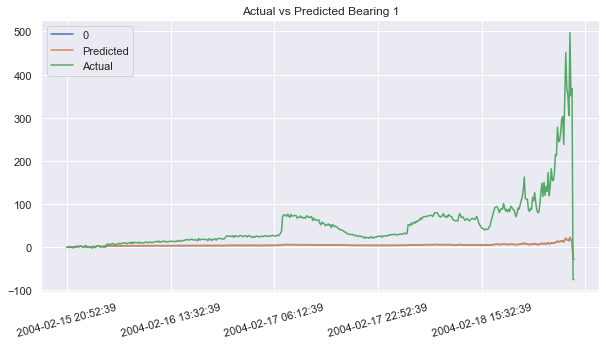

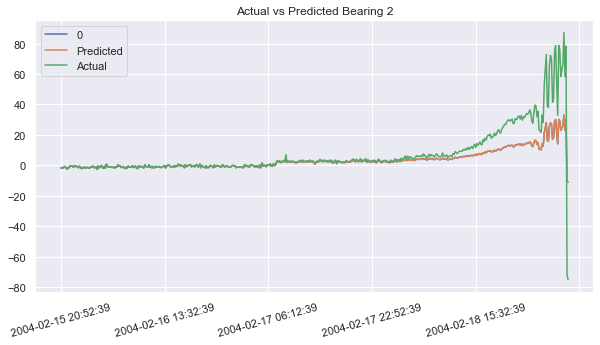

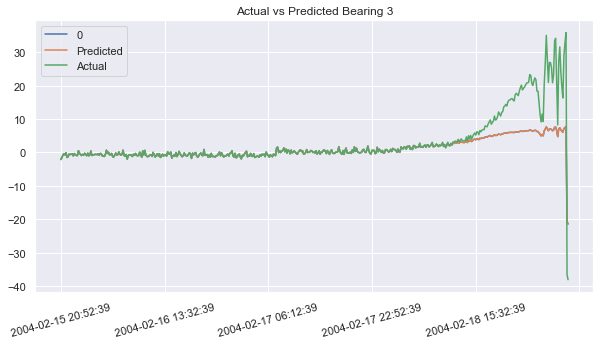

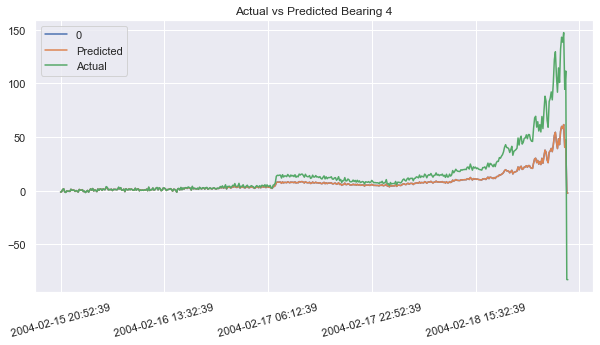

In [21]:
# visualization x_test prediction
# leading up to the bearing failure
for col in df.columns:
    x_test_array = np.array(x_test[col])
    x_test_pred = models[col].predict(x_test_array)
    
    df_test_pred = pd.DataFrame(x_test_pred)
    df_test_pred["Predicted"] = x_test_pred
    df_test_pred["Actual"] = x_test_array
    df_test_pred.index = x_test[col].index
    df_test_pred.plot(figsize = (10,5), title=f"Actual vs Predicted {col}" , legend = True) 
    plt.xticks(rotation=15)
    plt.show()

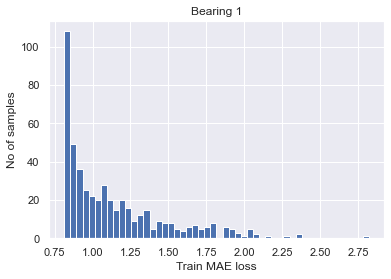

Reconstruction error threshold Bearing 1:  2.8202737517559946


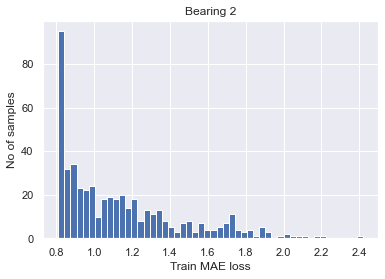

Reconstruction error threshold Bearing 2:  2.4176326979422478


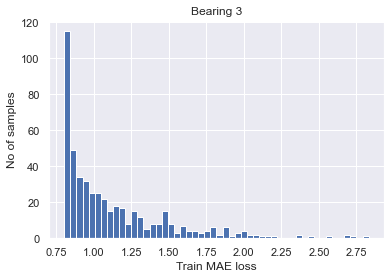

Reconstruction error threshold Bearing 3:  2.8314032960171986


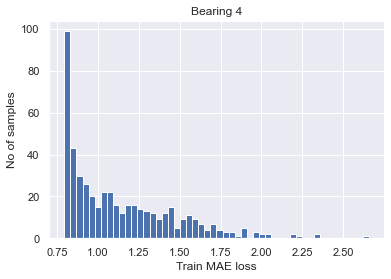

Reconstruction error threshold Bearing 4:  2.6555278305598105


In [68]:
# Get train MAE loss.
list_threshold = []
for col in df.columns:
    x_train_pred = models[col].predict(np.array(x_train[col]))
    train_mae_loss = np.mean(np.abs(x_train_pred - np.array(x_train[col])),axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.title(col)
    plt.show()

    # Get reconstruction loss threshold
    threshold = np.max(train_mae_loss)
    list_threshold.append(threshold)
    print(f"Reconstruction error threshold {col}: ", threshold)

## Existing

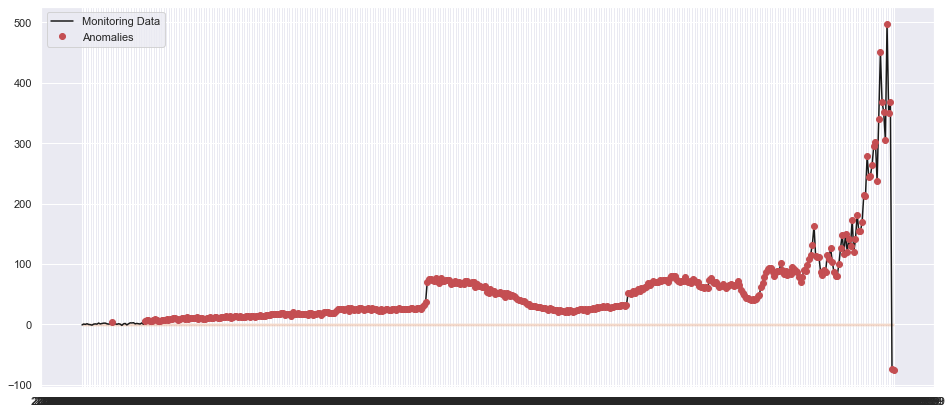

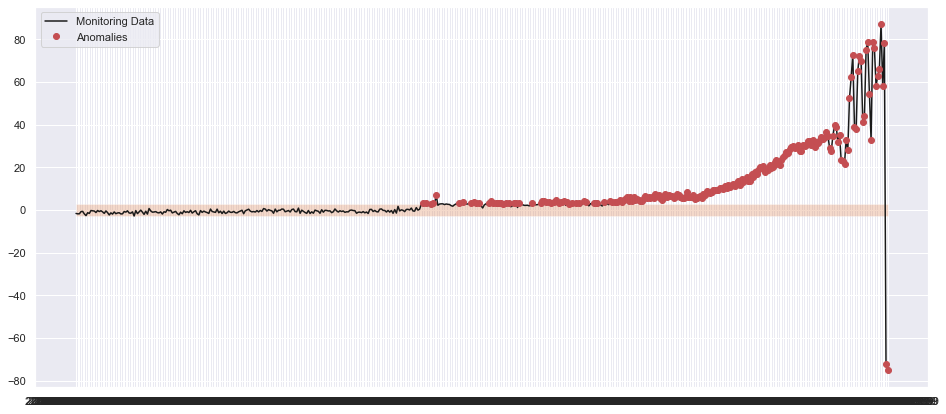

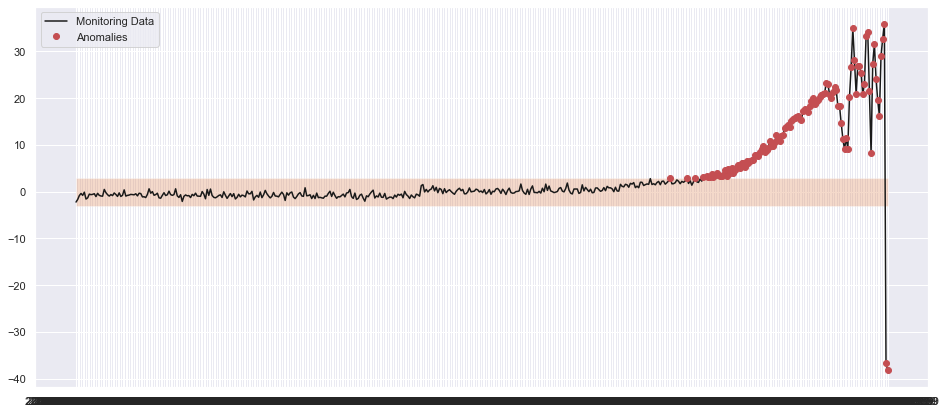

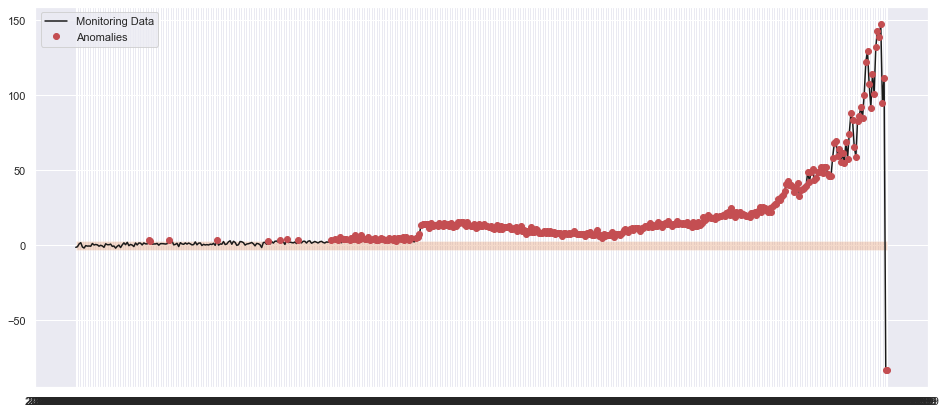

In [66]:
for col in df.columns:
    window_percentage = 20
    k = int(len(x_test[col]) * (window_percentage/100))
    N = len(x_test[col])

    get_bands = lambda data : (np.mean(x_train[col]) + 3*np.std(x_train[col]),
                               np.mean(x_train[col]) - 3*np.std(x_train[col]))

    bands = [get_bands(column[range(0 if i - k < 0 else i-k ,
                                    i + k if i + k < N else N)]) for i in range(0,N)]
    upper, lower = zip(*bands)

    # compute local outliers 
    anomalies = (x_test[col] > upper) | (x_test[col] < lower)

    # plotting
    plt.figure(figsize=(16,7))
    plt.plot(x_test.index,x_test[col],'k',label='Monitoring Data')
    plt.plot(x_test.index[anomalies],x_test[col][anomalies],'ro',label='Anomalies')
    plt.fill_between(x_test.index, upper, lower,facecolor='C1',alpha=.3)
    plt.legend()

    plt.show()